# **CA 3 - Part1, LLMs Spring 2025**

- **Name:**
- **Student ID:**

---
#### Your submission should be named using the following format: `CA3 - Part1_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email:

# Import libraries and Dependencies

In [2]:
!pip -q install datasets
!pip -q install transformers==4.36.0
!pip -q install accelerate flash_attn scikit-learn tqdm datasets

In [3]:
# !pip install --upgrade datasets transformers huggingface_hub accelerate flash_attn scikit-learn tqdm

In [1]:
from datasets import load_dataset, Dataset, Value
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import random

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [18]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 🧩Part 1: Judgement Strategies in LLM as a Judge

## 1.1 Load Dataset

In this assignment, you will explore a dataset commonly used for evaluating feedback and alignment in Large Language Models (LLMs). The goal is to help you become familiar with how such datasets are structured and how to extract meaningful information from them.

 use the 🤗 datasets library to download the following dataset:

> `prometheus-eval/Feedback-Bench`

> Link: https://huggingface.co/datasets/prometheus-eval/Feedback-Bench

> paper: https://arxiv.org/abs/2310.08491



In [4]:
feedback_bench_dataset = load_dataset("prometheus-eval/Feedback-Bench")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-eddf1add30d20be1.parquet:   0%|          | 0.00/7.24M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
seed = 25
random.seed(seed)
feedback_bench_dataset = feedback_bench_dataset['train'].shuffle(seed=seed)
example = feedback_bench_dataset[0]
print(feedback_bench_dataset.shape)
for key, value in example.items():
    print(f"{key}: {value[:100] if isinstance(value, str) else value}")

(1000, 16)
orig_instruction: I am a project manager for a software development company. We have a new client who wants to develop
orig_score3_description: The model frequently provides relevant responses and sometimes asks clarifying questions, maintainin
orig_score4_description: The model consistently provides relevant responses and often asks clarifying questions, ensuring a s
output: The response does touch upon relevant points such as discussing with the client, asking questions, a
orig_response: To understand the client's needs better, maybe try talking to them about what they want. It might he
orig_reference_answer: In order to manage this situation effectively and ensure the successful development of the web appli
orig_feedback: The response does touch upon relevant points such as discussing with the client, asking questions, a
orig_score1_description: The model consistently provides irrelevant responses and fails to ask clarifying questions, leading 
orig_score: 2
orig_criteria

## 1.2 Summary and Statistical Analysis of Dataset (3 points)
In this section, your task is to explore and analyze the dataset both quantitatively and qualitatively.

* Describe what the column represents.

* Identify columns with integer or numerical values.

* Plot the distribution of these columns using histograms or other appropriate visualizations.

In [6]:
feedback_bench_dataset.features

{'orig_instruction': Value(dtype='string', id=None),
 'orig_score3_description': Value(dtype='string', id=None),
 'orig_score4_description': Value(dtype='string', id=None),
 'output': Value(dtype='string', id=None),
 'orig_response': Value(dtype='string', id=None),
 'orig_reference_answer': Value(dtype='string', id=None),
 'orig_feedback': Value(dtype='string', id=None),
 'orig_score1_description': Value(dtype='string', id=None),
 'orig_score': Value(dtype='string', id=None),
 'orig_criteria': Value(dtype='string', id=None),
 'orig_score2_description': Value(dtype='string', id=None),
 'instruction': Value(dtype='string', id=None),
 'orig_score5_description': Value(dtype='string', id=None),
 'input': Value(dtype='string', id=None),
 'messages': [{'content': Value(dtype='string', id=None),
   'role': Value(dtype='string', id=None)}],
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
# feedback_bench_dataset = feedback_bench_dataset.cast_column('orig_score', Value('int64'))
# feedback_bench_dataset.features['orig_score'].dtype

In [7]:
def convert_score_to_int(example):
    try:
        example['orig_score'] = int(example['orig_score'])
    except ValueError:
        # Handle cases where conversion might fail (e.g., if there are non-numeric strings)
        # You might want to set it to a default value, or skip the example
        example['orig_score'] = -1 # Or np.nan for NaN values
    return example

feedback_bench_dataset = feedback_bench_dataset.map(convert_score_to_int)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
feedback_bench_dataset.features['orig_score'].dtype

'int64'

In [9]:
df = feedback_bench_dataset.to_pandas()

print("\nMissing Values Count per Column:")
print(df.isnull().sum())

print("\nMissing Values Percentage per Column:")
print(df.isnull().sum() / len(df) * 100)

# Optional: Visualizing missing values (for many columns)
# plt.figure(figsize=(12, 7))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values Heatmap')
# plt.show()


Missing Values Count per Column:
orig_instruction           0
orig_score3_description    0
orig_score4_description    0
output                     0
orig_response              0
orig_reference_answer      0
orig_feedback              0
orig_score1_description    0
orig_score                 0
orig_criteria              0
orig_score2_description    0
instruction                0
orig_score5_description    0
input                      0
messages                   0
__index_level_0__          0
dtype: int64

Missing Values Percentage per Column:
orig_instruction           0.0
orig_score3_description    0.0
orig_score4_description    0.0
output                     0.0
orig_response              0.0
orig_reference_answer      0.0
orig_feedback              0.0
orig_score1_description    0.0
orig_score                 0.0
orig_criteria              0.0
orig_score2_description    0.0
instruction                0.0
orig_score5_description    0.0
input                      0.0
messages        


Descriptive Statistics for orig_score:
count    1000.000000
mean        2.910000
std         1.420534
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
dtype: float64

Value Counts for orig_score:
1    220
2    214
3    185
4    198
5    183
Name: count, dtype: int64


/tmp/ipython-input-10-4265885868.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(scores_series, bins=len(scores_series.unique()), discrete=True, stat='count', palette='viridis')


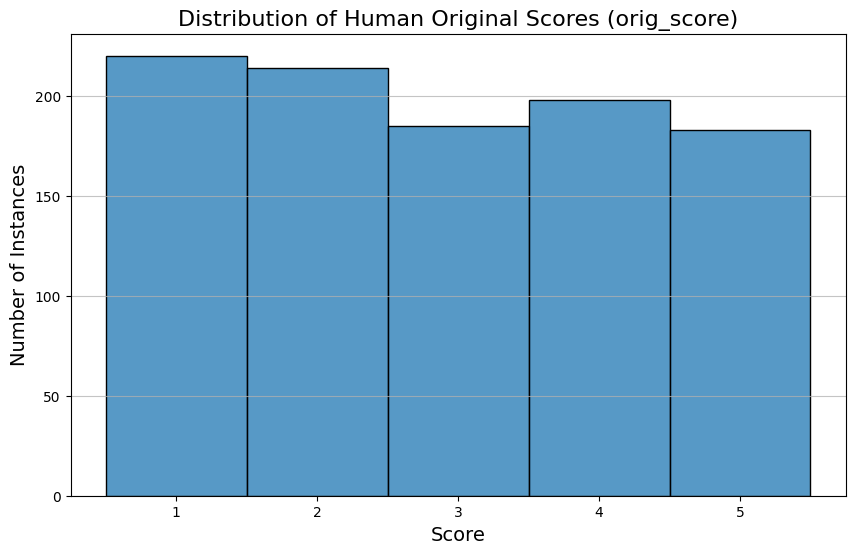

In [10]:
scores_series = pd.Series(feedback_bench_dataset['orig_score'])
print("\nDescriptive Statistics for orig_score:")
print(scores_series.describe())

print("\nValue Counts for orig_score:")
print(scores_series.value_counts().sort_index())

plt.figure(figsize=(10, 6))
sns.histplot(scores_series, bins=len(scores_series.unique()), discrete=True, stat='count', palette='viridis')
plt.title('Distribution of Human Original Scores (orig_score)', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(sorted(scores_series.unique()))
plt.grid(axis='y', alpha=0.75)
plt.show()


Descriptive Statistics for Text Lengths:
       instruction_length  response_length  criteria_length  \
count         1000.000000      1000.000000      1000.000000   
mean           487.452000       888.716000       144.497000   
std            261.777622       394.661984        68.079298   
min             66.000000        85.000000        38.000000   
25%            365.000000       608.000000        96.000000   
50%            458.000000       825.500000       116.000000   
75%            551.000000      1124.500000       191.000000   
max           2824.000000      2454.000000       458.000000   

       orig_feedback_length  reference_answer_length  
count           1000.000000              1000.000000  
mean             687.537000              1639.468000  
std              180.290208               449.979878  
min              329.000000                 0.000000  
25%              543.000000              1416.500000  
50%              688.500000              1697.000000  
75%  

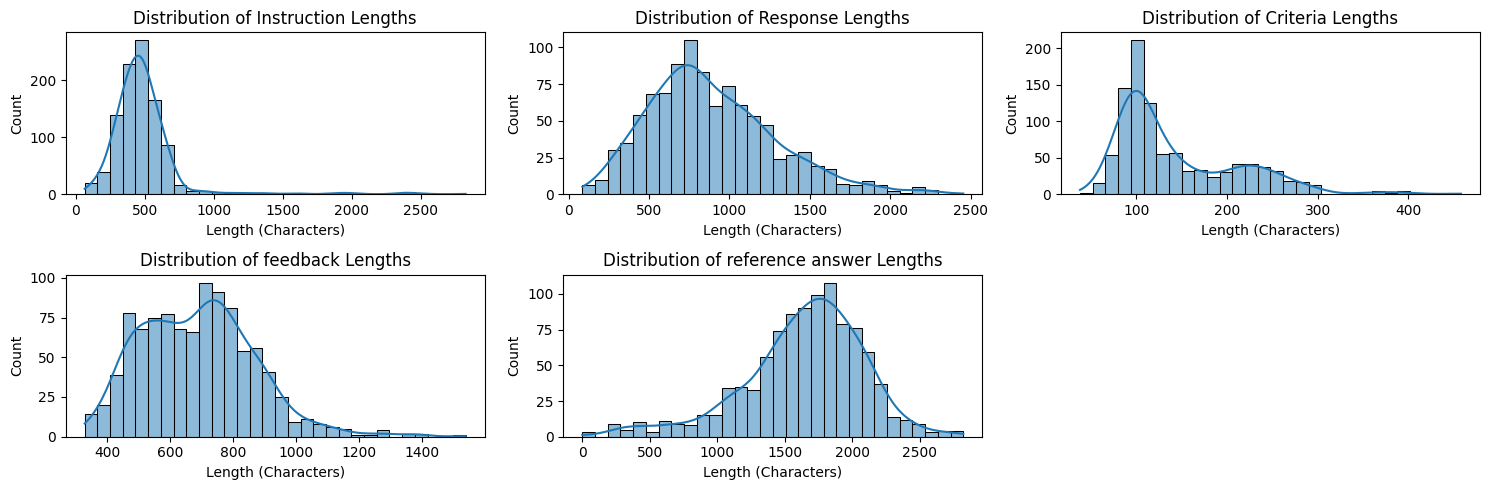

In [11]:
df['instruction_length'] = df['orig_instruction'].apply(lambda x: len(str(x)))
df['response_length'] = df['orig_response'].apply(lambda x: len(str(x)))
df['criteria_length'] = df['orig_criteria'].apply(lambda x: len(str(x)))
df['orig_feedback_length'] = df['orig_feedback'].apply(lambda x: len(str(x)))
df['reference_answer_length'] = df['orig_reference_answer'].apply(lambda x: len(str(x)))

print("\nDescriptive Statistics for Text Lengths:")
print(df[['instruction_length', 'response_length', 'criteria_length', 'orig_feedback_length', 'reference_answer_length']].describe())

plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
sns.histplot(df['instruction_length'], bins=30, kde=True)
plt.title('Distribution of Instruction Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
sns.histplot(df['response_length'], bins=30, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 3)
sns.histplot(df['criteria_length'], bins=30, kde=True)
plt.title('Distribution of Criteria Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 4)
sns.histplot(df['orig_feedback_length'], bins=30, kde=True)
plt.title('Distribution of feedback Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 5)
sns.histplot(df['reference_answer_length'], bins=30, kde=True)
plt.title('Distribution of reference answer Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

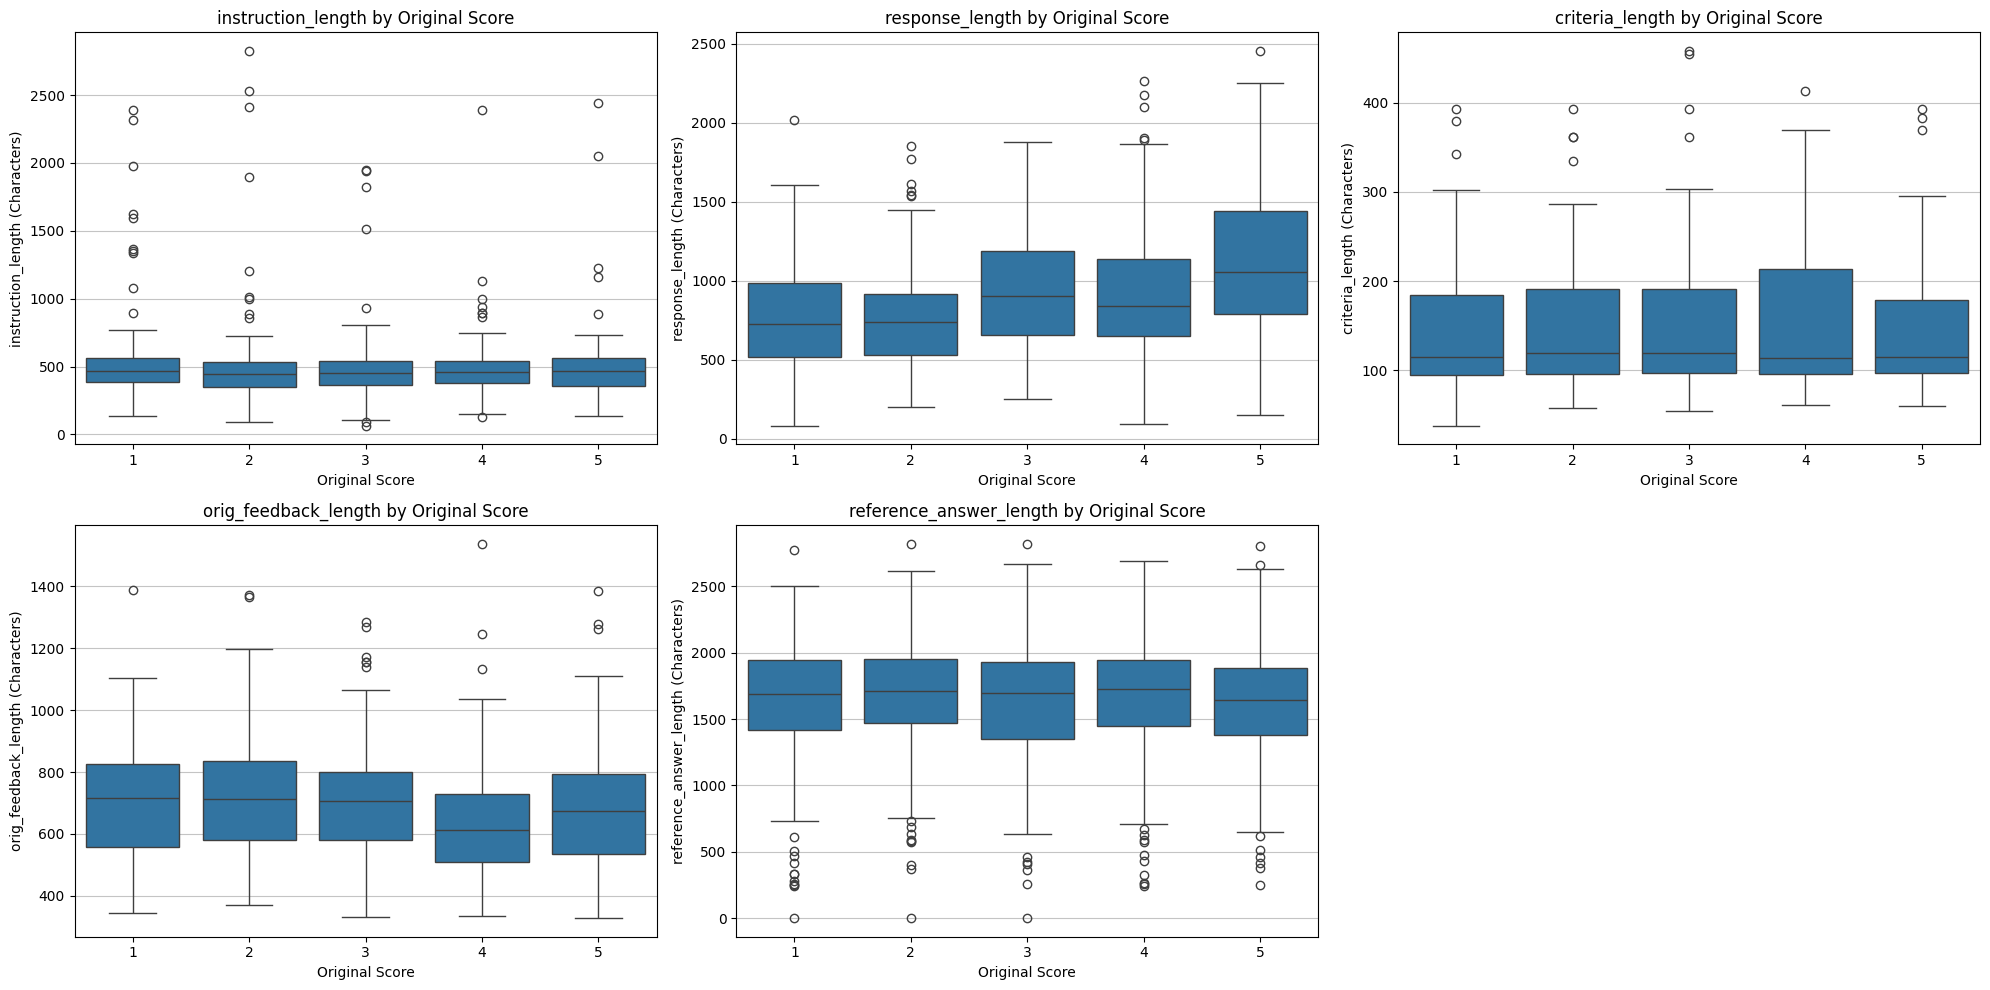


Correlation between lengths and Original Score:
instruction_length: -0.03056677521046996
response_length: 0.31993920217691973
criteria_length: -0.005478289442957333
orig_feedback_length: -0.10119380178217377
reference_answer_length: -0.009785699028506593


In [12]:
col = ['instruction_length', 'response_length', 'criteria_length', 'orig_feedback_length', 'reference_answer_length']

plt.figure(figsize=(20, 10))
for i in range(len(col)):
  plt.subplot(2, 3, i+1)
  sns.boxplot(x='orig_score', y=df[col[i]], data=df)
  plt.title(f'{col[i]} by Original Score')
  plt.xlabel('Original Score')
  plt.ylabel(f'{col[i]} (Characters)')
  plt.grid(axis='y', alpha=0.75)

plt.tight_layout() #
plt.show()

print("\nCorrelation between lengths and Original Score:")
for i in range(len(col)):
  print(f"{col[i]}: {df['orig_score'].corr(df[col[i]])}")



| Field | What it holds | Typical length / shape | Raw dtype in HF dataset | Usable as numeric? | Note |
|-------|---------------|------------------------|-------------------------|--------------------|------|
| **__index_level_0__** | Parquet-generated row ID (0 – 999) | single integer | `int64` | **yes** | Only an index; seldom used analytically |
| **orig_instruction** | Bare-bones user task the answer must solve | ≈ 70 – 2 800 chars | `string` | no | Prompt given to the model under evaluation |
| **instruction** | Full *judge* prompt (system rubric + user task) | up to ≈ 7 000 chars | `string` | no | Used to instruct the evaluator model |
| **input** | Extra task input (almost always empty) | string | `string` | no | Optional additional context |
| **messages** | Two-item chat log: evaluator *system* + *user* task | `list[dict]` | `list` | no | Same info as `instruction`, in chat-format |
| **orig_response** | Candidate answer that is being critiqued | ≈ 80 – 2 500 chars | `string` | no | The thing to grade |
| **orig_reference_answer** | Gold answer that would earn score 5 | 0 – 2 800 chars | `string` | no | Ideal solution under the rubric |
| **orig_score1_description** | Rubric text for **score 1** | 40 – 240 chars | `string` | no | First of five tier descriptions |
| **orig_score2_description** | Rubric text for **score 2** | 40 – 240 chars | `string` | no | – |
| **orig_score3_description** | Rubric text for **score 3** | 40 – 240 chars | `string` | no | – |
| **orig_score4_description** | Rubric text for **score 4** | 40 – 240 chars | `string` | no | – |
| **orig_score5_description** | Rubric text for **score 5** | 40 – 240 chars | `string` | no | – |
| **orig_criteria** | Name of capability being judged (e.g. *multitasking*) | ≈ 40 chars | `string` | no | One per row |
| **orig_feedback** | GPT-4 explanation of the gold score | ≈ 330 – 1 500 chars | `string` | no | Training target for feedback generation |
| **orig_score** | Gold numeric label (1 – 5) matching `orig_feedback` | single digit | `string` (cast → `int`) | **yes** after convert | Class label |
| **output** | Slot for *your model’s* feedback + score | ≈ 340 – 1 550 chars | `string` | no | Empty in raw data; filled by your evaluator |

## 1.3 Load Phi-3-3.8B model

Use the Hugging Face transformers library to load the model and tokenizer:

Model: https://huggingface.co/microsoft/Phi-3-mini-4k-instruct


In [17]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 1.4 Phi Judgemnt Performance Evaluation (23 points)

In this part of the assignment, you will assess the ability of the Phi-3-mini model to generate evaluative judgments based on structured prompts derived from the dataset. Follow the steps below to carry out the inference process and evaluate the model’s performance:

**1. Prompt Construction:**


Use relevant columns from the dataset (e.g., orig_instruction,orig_criteria, etc.) to construct informative prompts that the model can respond to meaningfully.


**2. Model Inference:**

Select a random sample of 50 entries from the dataset. For each entry, feed the constructed prompt into the Phi model and generate a corresponding judgment and score.

*Don't forget applying chat template 😊*

**3. Output Parsing:**

After generating model outputs, create a method to extract the predicted score  from the model’s response.


**4. Metric Selection and Performance Analysis:**

Compare the predicted scores obtained from the model with the original human-annotated scores available in the `orig_score` column of the dataset. This step will help you measure how well the model’s outputs align with refrence judge.

### 1.4.1 Prompt Construction (2 points)

In [ ]:
# Write Your Code Here

### 1.4.2 Model Inference (5 points)

In [ ]:
# Write Your Code Here

### 1.4.3 Extract Score (Output Parsing) (5 points)

In [ ]:
# Write Your Code Here

### 1.4.4 Metric Selection and Performance Analysis (11 points)

Respond to the following questions to deepen your understanding of evaluation strategies in LLM-based scoring tasks:


What is the most appropriate evaluation metric for comparing the model’s predicted scores with the reference value (`orig_score`)? Consider the type of scores (e.g., continuous, ordinal, or categorical) when making your choice. (3 points)

Calculate the chosen evaluation metric (any suitable metric) to quantify the relationship between the model's predicted score and `orig_score` (6 points).

Is accuracy a suitable metric in this context? Why or why not? (2 points)







`# WRITE YOUR ANSWER HERE`

In [ ]:
# Write Your Code Here

`# WRITE YOUR ANSWER HERE`

## 1.5 Alternative Evaluation Strategies (15 points)

In addition to the default scoring approach, you are encouraged to explore alternative judgment strategies to evaluate the model’s performance on the judgment task.


---

### Examples of Alternative Approaches

#### Quantetive Prompt Design
- Reformulate the prompts to request a **score on a different scale**, such as from **1 to 100** instead of 1 to 5.
- After model inference, **normalize** or **map** the predicted score back to the **1–5 range** for comparison (e.g., using simple scaling or binning).

#### Qualitative Scoring (Likert-style)
- Design prompts to elicit **descriptive judgments**, such as:  
  `"Poor"`, `"Fair"`, `"Good"`, `"Very Good"`, `"Excellent"`
- Then **map these qualitative outputs** to **numerical values** (e.g., 1 to 5) to enable metric-based evaluation.



In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here


# 🧩 Part 2: Creating Preference Data Using LLM as Judge

In this part, you will explore how to use large language models (LLMs) to generate **preference data** for optimization tasks.

We will compare two models:

- `Qwen/Qwen1.5-1.8B-Chat`
- `stabilityai/stablelm-2-zephyr-1_6b`

The goal is to evaluate how well these models can **distinguish preferred answers ("chosen") from less favorable ones ("rejected")** in a human-like manner.

---

## 2.1 Download the Models and Dataset

- Load the following two models from Hugging Face:
  - `Qwen/Qwen1.5-1.8B-Chat`
  - `stabilityai/stablelm-2-zephyr-1_6b`

- Download the dataset:  
  [`HumanLLMs/Human-Like-DPO-Dataset`](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset)

---

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

## 2.2 Dataset Exploration (1 point)


- Analyze the `HumanLLMs/Human-Like-DPO-Dataset`.
  - Describe the dataset structure and columns.

- **Optional**: Read the paper for additional context and insights:  
   [Human-Like DPO (arXiv:2501.05032)](https://arxiv.org/pdf/2501.05032)



`# WRITE YOUR ANSWER HERE`

## 2.3 Judging Setup (3 points)

- Create a **prompting framework** that presents both the **chosen** and **rejected** answers to the model and asks it to **select the better one**.


Example prompt structure:
> "Here is a prompt and two responses. Please choose the better response based on helpfulness, relevance, and coherence.  
>  
> Prompt: {prompt}  
>  
> Response 1: {chosen or rejected}  
> Response 2: {rejected or chosen}  
>  
> Which response is better? Reply with 'Answer 1' or 'Answer 2'."
---

In [ ]:
## Write Your Code Here

## 2.4 Model Comparison (10 points)

- Run inference using both models on a **sample of the dataset** (e.g., 200–500 instances from dataset). (2 points)
- Compare each model's judgments to the **ground truth** (i.e., whether it preferred the "chosen" response). (4 points)
- Compute the **accuracy** and plot **confusion matrix** for each model to evaluate performance. (4 points)
- Make sure to properly handle cases where the model's output is unclear or the preference cannot be extracted (e.g., skip or categorize as "unkowned").

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here